# Baysian Two-way Fixed Effects

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)
df

,island_ids,years,region_codes,prefecture_codes,populations,treatment_group,treatment_group_mainland,year_bridges_opened,after_treated,year_connect_mainland,...,income,area_km2,distance_m,elementary_school,junior_high_school,high_school,hospital,population_change_rate,control_group,time_since_intervention
0,67,1970,32202,32,NaN,1,1,1999,0,1999,...,NaN,0.28,615.0,NaN,NaN,NaN,NaN,NaN,0,-29
1,67,1975,32202,32,NaN,1,1,1999,0,1999,...,NaN,0.28,615.0,NaN,NaN,NaN,NaN,NaN,0,-24
2,67,1980,32202,32,NaN,1,1,1999,0,1999,...,NaN,0.28,615.0,NaN,NaN,NaN,NaN,NaN,0,-19
3,67,1985,32202,32,NaN,1,1,1999,0,1999,...,4.243674e+07,0.28,615.0,NaN,NaN,NaN,NaN,NaN,0,-14
4,67,1990,32202,32,NaN,1,1,1999,0,1999,...,4.786833e+07,0.28,615.0,NaN,NaN,NaN,NaN,NaN,0,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,226,2000,39424,39,398.0,1,1,1957,1,1957,...,5.113370e+02,0.56,110.0,NaN,NaN,NaN,NaN,-4.784689,0,43
1896,226,2005,39424,39,365.0,1,1,1957,1,1957,...,4.533435e+02,0.56,110.0,NaN,NaN,NaN,NaN,-8.291457,0,48
1897,226,2010,39424,39,343.0,1,1,1957,1,1957,...,3.903833e+02,0.56,110.0,NaN,NaN,NaN,NaN,-6.027397,0,53
1898,226,2015,39424,39,284.0,1,1,1957,1,1957,...,4.064721e+02,0.56,110.0,NaN,NaN,NaN,NaN,-17.201166,0,58


## TWFE

$$
Y_{it} = \alpha_i + \lambda_t + \delta T_{it} + \epsilon_{it}
$$

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


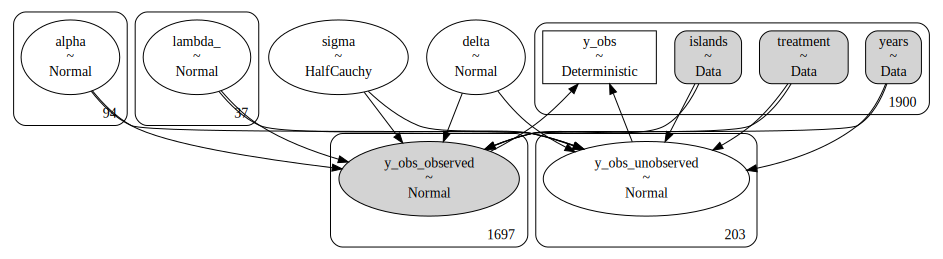

In [12]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])


with pm.Model() as twfe:
    # data
    islands = pm.Data('islands', df['island_ids'])
    years = pm.Data('years', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])

    # priors
    alpha = pm.Normal('alpha', mu=0, sigma=100, shape=len(df['island_ids'].unique()))
    lambda_ = pm.Normal('lambda_', mu=0, sigma=100, shape=len(df['years'].unique()))
    delta = pm.Normal('delta', mu=0, sigma=100)
    sigma = pm.HalfCauchy('sigma', beta=100)

    # expectation
    mu = alpha[islands] + lambda_[years] + delta * treatment

    # likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(twfe)

In [13]:
with twfe:
    init_vals = {'delta': 82}
    trace_twfe = pm.sample(
        draws=2000,
        tune=2000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics


In [14]:
az.summary(trace_twfe, hdi_prob=.95, var_names=['delta', 'sigma'])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,538.221,92.844,348.161,711.006,1.009,0.715,8478.0,3056.0,1.0
sigma,4987.307,88.638,4816.226,5163.587,1.098,0.777,6510.0,3136.0,1.0


/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'lambda_'}>,
        <Axes: title={'center': 'lambda_'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'y_obs_unobserved'}>,
        <Axes: title={'center': 'y_obs_unobserved'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'y_obs'}>,
        <Axes: title={'center': 'y_obs'}>]], dtype=object)

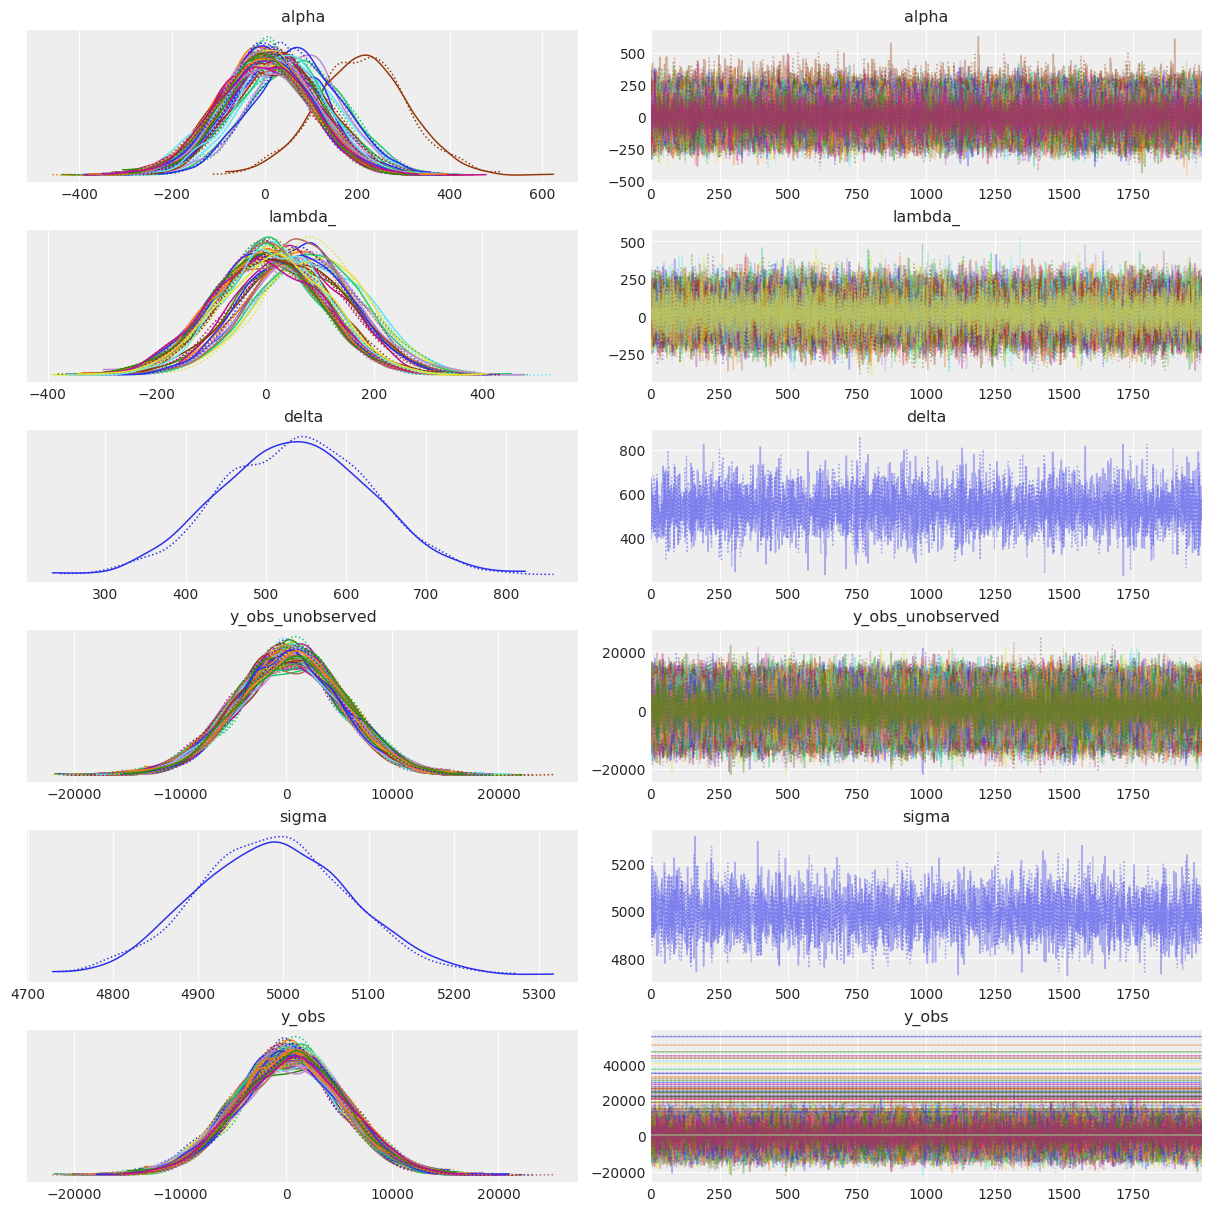

In [14]:
az.plot_trace(trace_twfe);

In [16]:
posterior_samples = trace_twfe.posterior

delta_samples = posterior_samples['delta']

# 0以上のサンプルの割合を計算
prob_delta_positive = np.mean(delta_samples > 0)

print(f"Pr(intercept > 0) = {prob_delta_positive:.4f}")

Pr(intercept > 0) = 1.0000


In [15]:
with twfe:
    pm.compute_log_likelihood(trace_twfe)

Output()

In [16]:
az.loo(trace_twfe)

Computed from 4000 posterior samples and 1697 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -16870.22   143.80
p_loo       24.81        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1697  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## 階層ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


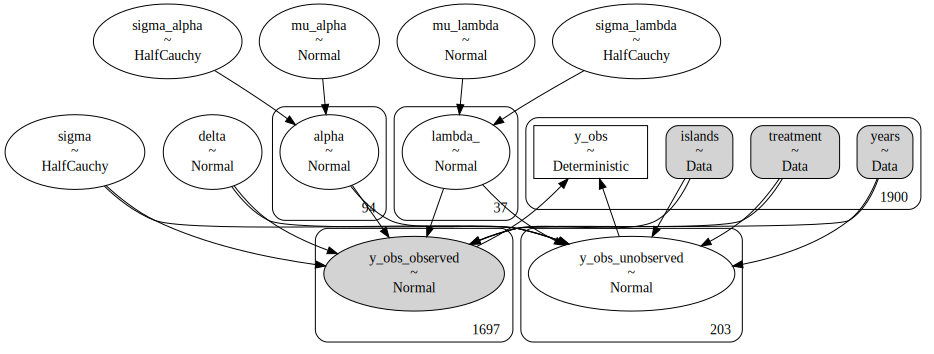

In [17]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_years = pd.factorize(df['years'])


with pm.Model() as twfe_h:
    # data
    islands = pm.Data('islands', df['island_ids'])
    years = pm.Data('years', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])

    # priors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=100)
    sigma_alpha = pm.HalfCauchy('sigma_alpha', beta=100)
    mu_lambda = pm.Normal('mu_lambda', mu=0, sigma=100)
    sigma_lambda = pm.HalfCauchy('sigma_lambda', beta=100)
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=len(df['island_ids'].unique()))
    lambda_ = pm.Normal('lambda_', mu=mu_lambda, sigma=sigma_lambda, shape=len(df['years'].unique()))
    delta = pm.Normal('delta', mu=0, sigma=100)
    sigma = pm.HalfCauchy('sigma', beta=100)

    # expectation
    mu = alpha[islands] + lambda_[years] + delta * treatment

    # likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(twfe_h)

In [ ]:
with twfe_h:
    trace_twfe_h = pm.sample(
        draws=2000,
        tune=2000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42,
    )

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [19]:
az.summary(trace_twfe_h, hdi_prob=.95, var_names=['delta', 'sigma'])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,44.003,80.434,-107.099,208.464,1.167,1.071,4739.0,3398.0,1.0
sigma,1034.103,18.643,995.908,1069.764,0.347,0.246,2864.0,2524.0,1.0


/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


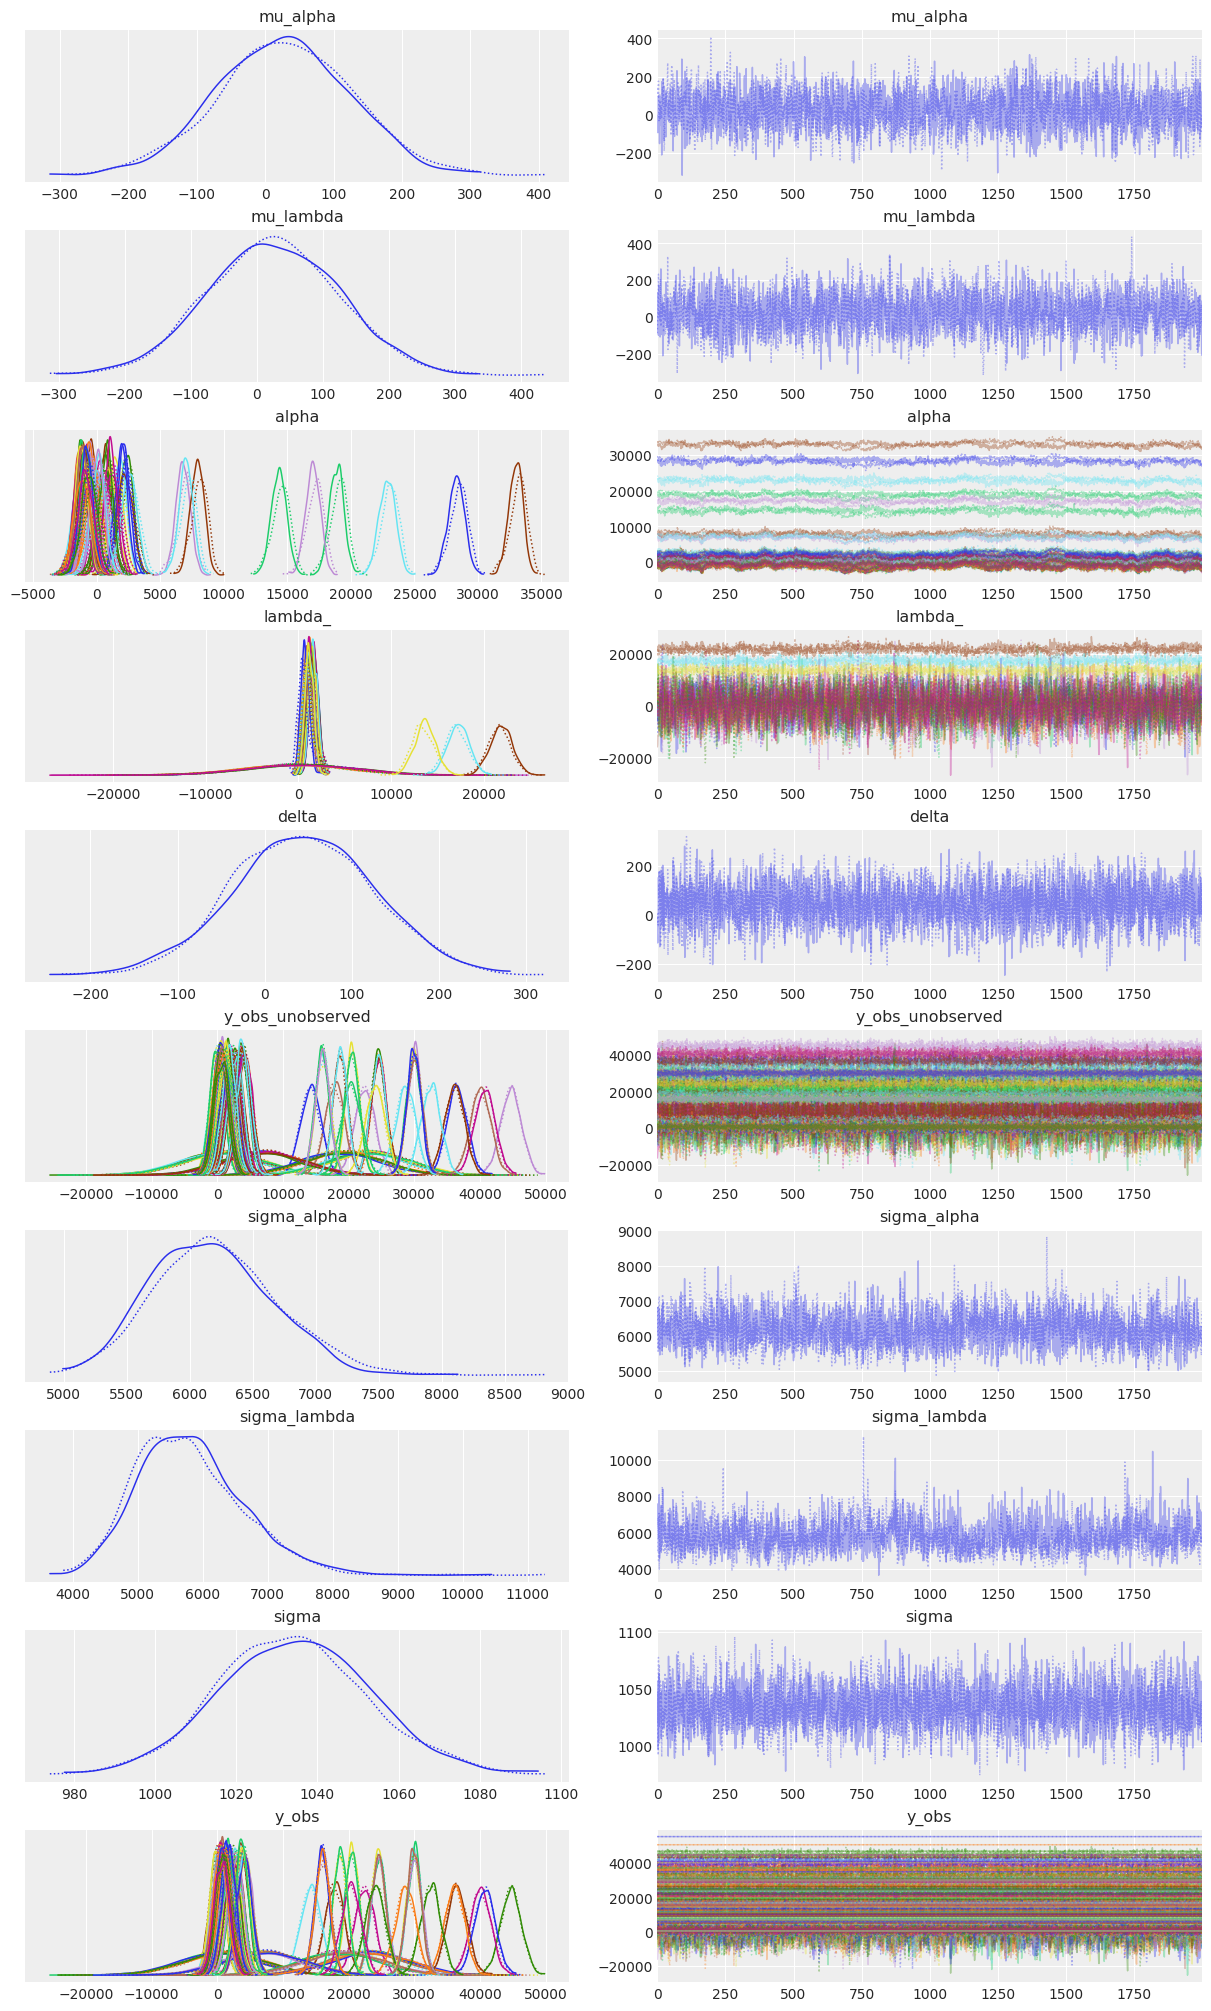

In [20]:
az.plot_trace(trace_twfe_h);

In [24]:
posterior_samples = trace_twfe_h.posterior

delta_samples = posterior_samples['delta']

# 0以上のサンプルの割合を計算
prob_delta_positive = np.mean(delta_samples > 0)

print(f"Pr(intercept > 0) = {prob_delta_positive:.4f}")

Pr(intercept > 0) = 0.7030


In [22]:
with twfe_h:
    pm.compute_log_likelihood(trace_twfe_h)

Output()

In [23]:
az.loo(trace_twfe)

Computed from 4000 posterior samples and 1697 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -16870.22   143.80
p_loo       24.81        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     1697  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%